# 미국장과 한국장 연관성

주식 단타를 하는 데이트레이더들이 대부분 오버나잇 안한다고 한다. 그 이유는 다음날 지수가 어떻게 될지 모르기 때문에. 미국장이 떨어지면 한국장도 떨어지는 경향이 있다고 한다. 정말 그렇다면 그걸로 수익을 낼 수 있지 않을까 생각해 파이썬으로 알아보기로 했다. 

pandas_datareader로 데이터를 받아온다. 코스피 지수, S&P500 지수 대신 'KODEX200', 'SPDR S&P 500 ETF Trust' ETF를 사용했다. 백테스팅 기간은 2010년도부터. 비교를 위해 일별등락률을 계산해서 추가한다. 

<AxesSubplot:title={'center':'SPY'}, xlabel='Date'>

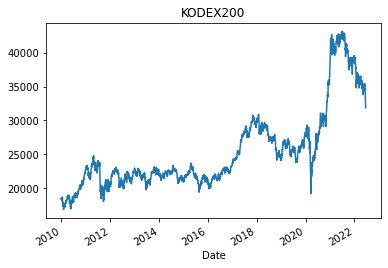

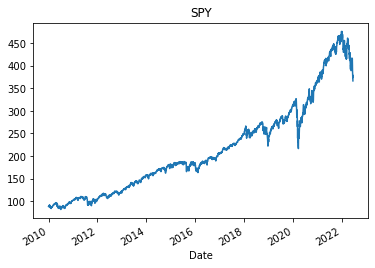

In [1]:
from pandas_datareader import data as web
import matplotlib.pyplot as plt

# KODEX 200
kdx = web.DataReader('069500', 'naver', start='2010-01-01')
kdx['Close'] = kdx['Close'].astype(int) # 이유는 모르겠으나 주가가 문자열로 저장되어 있다.
kdx['ret'] = kdx['Close'].pct_change()
kdx['Close'].plot(title="KODEX200")
plt.figure()

# SPDR S&P 500 ETF Trust (SPY)
spy = web.DataReader('SPY', 'yahoo', start='2010-01-01')
# 프레임워크 오류로 마지막 날 동일날짜 데이터가 두 개 있는 경우가 있다. 
if spy.index[-1] == spy.index[-2]:
    spy = spy[:-1]
spy['ret'] = spy['Adj Close'].pct_change()
spy['Adj Close'].plot(title="SPY")


2010년도부터 현재까지 미국장과 한국장 그래프

## 일별수익률 커브 비교
일별 수익률 그래프를 비교해 본다. 일별 수익률은 전일에 비해 몇 퍼센트 올랐는지만 비교하기 때문에 장기적인 그래프 모양과 상관없다. 
전체적인 데이터를 비교하기엔 양이 너무 많아 최근 100일만 나타내 본다. 

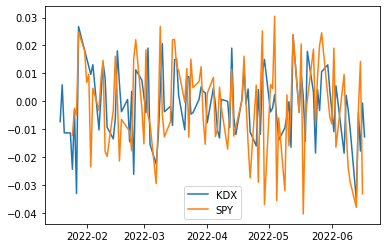

In [2]:
plt.figure()
plt.plot(kdx['ret'][-100:], label="KDX")
plt.plot(spy['ret'][-100:], label="SPY")
plt.legend()

미국장이 다음 날 한국장에 미치는 영향을 알고 싶다. 한국과 미국 증시 개장일이 다르기에 미국 개장일 바로 다음 한국 개장일이 아닌 경우는 제외한다. 그 사이에 무슨 이벤트가 생겨 연속성이 없어 질 수 있기에 제외하는 편이 낫다고 생각했다.

In [3]:
import datetime
import pandas as pd

nextOpenDayofS = (spy.index + datetime.timedelta(days=1)) & kdx.index
beforeOpenDayofK = spy.index  & (nextOpenDayofS - datetime.timedelta(days=1))
finalK = (beforeOpenDayofK + datetime.timedelta(days=1)) & nextOpenDayofS

nspy = spy[spy.index.isin(beforeOpenDayofK)]
nkdx = kdx[kdx.index.isin(finalK)]

len(nspy), len(nkdx)

/var/folders/tk/1dsltsc50rgfq9t3krytny280000gn/T/ipykernel_1345/788358586.py:4: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  nextOpenDayofS = (spy.index + datetime.timedelta(days=1)) & kdx.index
/var/folders/tk/1dsltsc50rgfq9t3krytny280000gn/T/ipykernel_1345/788358586.py:5: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  beforeOpenDayofK = spy.index  & (nextOpenDayofS - datetime.timedelta(days=1))
/var/folders/tk/1dsltsc50rgfq9t3krytny280000gn/T/ipykernel_1345/788358586.py:6: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  finalK = (beforeOpenDayofK + datetime.timedelta(days=1

(2372, 2372)

In [4]:
num_same = 0
num_diff = 0
for a, b in zip(nspy['ret'], nkdx['ret']):
    if (a>=0 and b>=0) or (a<=0 and b<=0):
        num_same += 1
    else:
        num_diff += 1

percentage = num_same / (num_same + num_diff) * 100
print(f"total samples: {num_diff+num_same}")
print(f"same trend: {num_same} times")
print(f"{percentage}%")

total samples: 2372
same trend: 1521 times
64.12310286677909%


한국장(코스피)은 64% 확률로 미국장(S&P500)과 같은 방향으로 움직인다. 
혹시 몰라 기간을 2002년도부터(그 이전은 데이터가 없다.) 테스트해도 2305/3703, 62% 같은 방향으로 움직인다. 

실제로 매매하면 어떻게 될지 벡테스팅을 해보겠다. 그래도 확률이 반 이상이니 매번 매매하면 수익이 날까 생각이 들어도, 방향이 다를 때 크게 손실 나면 의미가 없다. etf 공매도도 가능한다고 가정하고, 미국장이 하락하면 

In [38]:
cumret = 1
buyhold = 1
commission = 0.002
for s, k in zip(nspy['ret'], nkdx['ret']):
    # long if spy increases, short if spy decreases
    if s >= 0:
        cumret *= (1 + k) - commission
    else:
        cumret *= (1 - k) - commission
    
    buyhold *= (1 + k)

print(cumret)
print(buyhold)

12.486763170740101
2.0371383964543033


2010년부터 미국장이 상승하면 매매 시 동일기간 코덱스 보유에 비해 약 1000% 수익률을 자랑한다. 
문제는 현재 한 번 매매 시 수수료를 0.2%로 설정했지만 이를 0.3%로 설정하면 1.16배, 동일기간 보유에 비해 -84% 수익이다. 
이 전략은 효과적이긴 하나 매일 매매하기 떄문에 수수료에 많이 좌우된다. 

나중에 알고보니 코스피 지수는 야간선물 지수 방향을 따라가는 경우가 많다고 한다.  

"야간선물 지수와 코스피지수 시초가가 똑같은 방향으로 움직인 적중률이 81.3%나 된다. 야간선물 시장과 같은 시각에 장을 마치는 뉴욕 증시의 다우존스 지수와 S&P500 지수의 적중률은 71.5%, 77.7%였으며 기술주가 많은 나스닥 지수의 경우는 69.3% 정도였다."
https://biz.chosun.com/site/data/html_dir/2012/08/16/2012081602666.html 